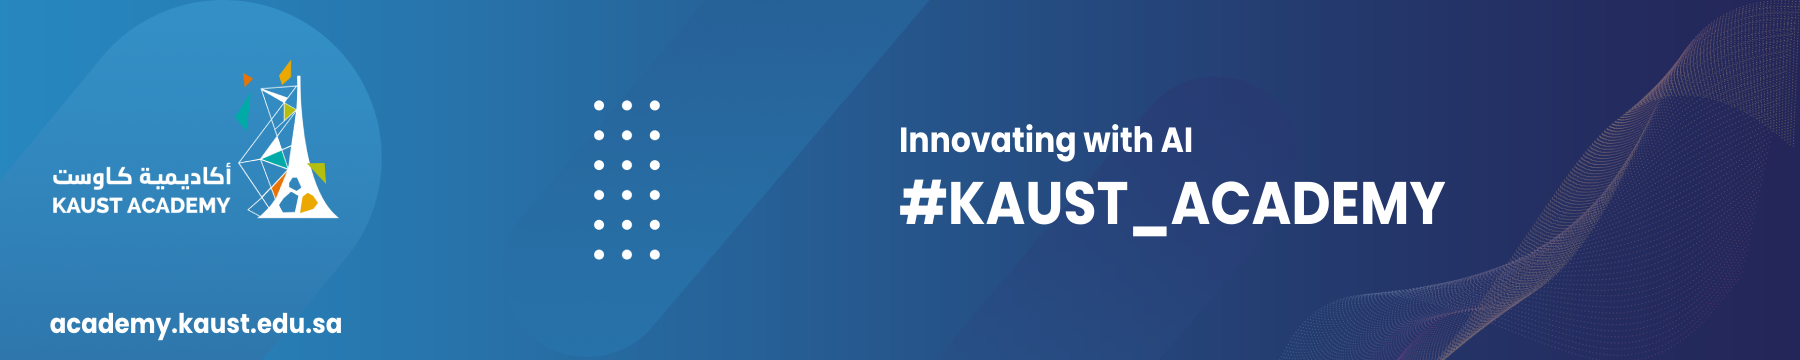



# 2-Introduction to Self-Attention: Motivation & Conceptual Overview



In the last lab, we studied the **Attention mechanism** in encoder-decoder models.

💡 Attention lets the decoder **focus** on specific input tokens instead of relying on one context vector.

We computed:
$
\alpha_i = \text{softmax}(score(s_t, h_i))
\quad,\quad
c_t = \sum_i \alpha_i h_i
$

👀 This helped the decoder decide **where to look** at each step.

---

## ❗ Limitation of Classic Attention

While helpful, this setup:

- Only works in **encoder-decoder** settings.
- Cannot model relationships **within the input itself**.
- Depends on **step-by-step decoding** (slow and sequential).

> ❌ We can't use it to let words in a sentence **interact with each other** in parallel.




---

## 🌟 2- Motivation for Self-Attention

>  **Self-Attention** lets each token build its own representation by looking at the entire input sentence — including itself.
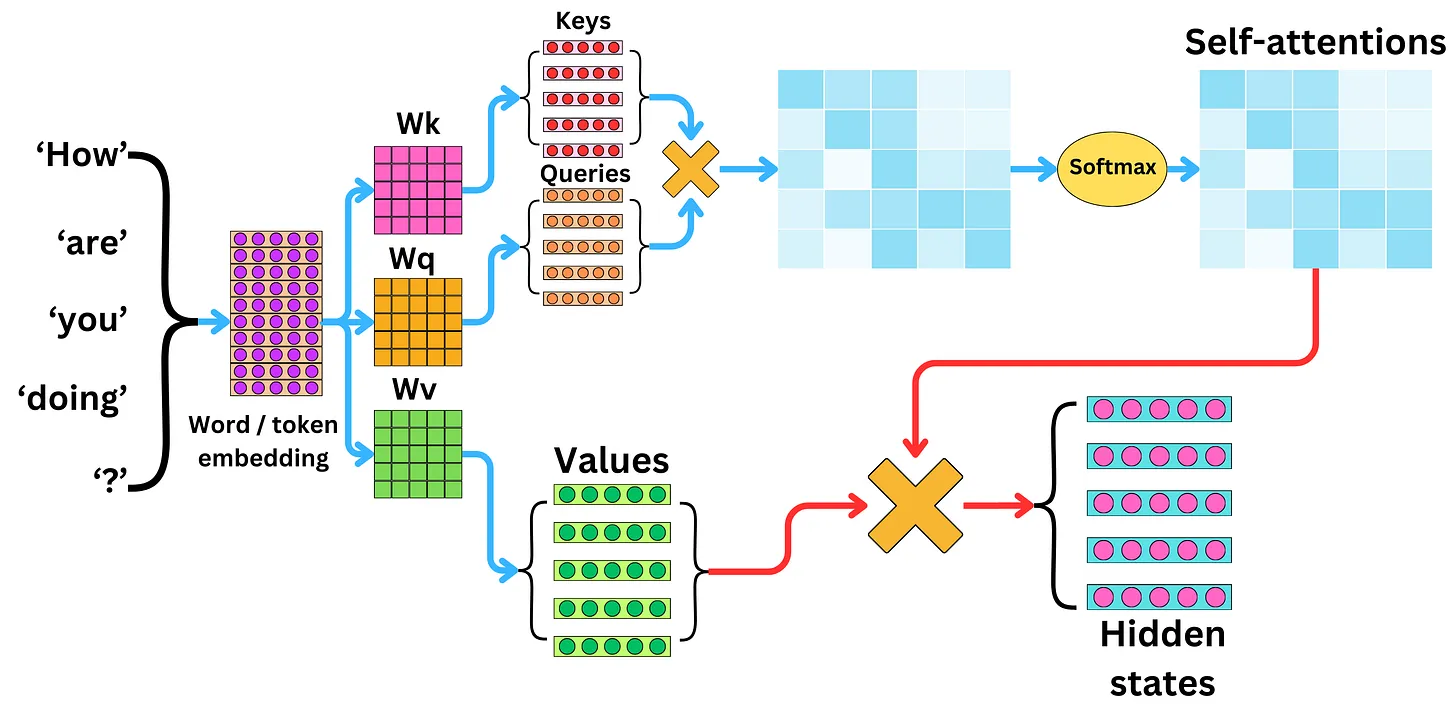

---

## 🤔 How Does It Work?

For each token, we create:
- Query vector **Q** (What am I looking for?)
- Key vector **K** (What do I contain?)
- Value vector **V** (What do I give?)

Then we compute:
$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V
$

⚙️ This means every token **weighs** the importance of every other token and gathers information accordingly.

---

## 🧠 Why It Matters

1- Captures **global dependencies** (no matter the distance)  
2-**No recurrence** → fully parallelizable  
3- Forms the backbone of **Transformer models** like BERT, GPT, T5...





In [1]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from collections import Counter
import re


In [2]:

class SelfAttentionDemo:
    def __init__(self, embed_dim=64):
        self.embed_dim = embed_dim
        # Initialize weight matrices for Q, K, V transformations
        self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
        print(f" SelfAttentionDemo initialized with embedding dimension: {embed_dim}")

demo = SelfAttentionDemo(embed_dim=64)
print(f"Weight matrices created:")
print(f"- W_q (Query): {demo.W_q.weight.shape}")
print(f"- W_k (Key): {demo.W_k.weight.shape}")
print(f"- W_v (Value): {demo.W_v.weight.shape}")

 SelfAttentionDemo initialized with embedding dimension: 64
Weight matrices created:
- W_q (Query): torch.Size([64, 64])
- W_k (Key): torch.Size([64, 64])
- W_v (Value): torch.Size([64, 64])


In [4]:
#Create sample sentence and embeddings
sentence = "the cat sat on the mat"
tokens = sentence.lower().split()

print("🔤 INPUT DATA:")
print(f"Original sentence: '{sentence}'")
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")

# Create simple word embeddings for demonstration
def create_sample_embeddings(tokens, embed_dim=64):
    """Create simple word embeddings for demonstration"""
    # Create vocabulary
    vocab = {token: i for i, token in enumerate(set(tokens))}
    print(f"\nVocabulary mapping: {vocab}")

    # Create random embeddings ( would be learned but here just an example )
    torch.manual_seed(42)
    embedding_matrix = torch.randn(len(vocab), embed_dim)

    # Convert tokens to embeddings
    token_ids = [vocab[token] for token in tokens]
    embeddings = embedding_matrix[token_ids]

    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    print(f"Token embeddings shape: {embeddings.shape}")
    print(f"Each token is represented by a {embed_dim}-dimensional vector")

    return embeddings, vocab

# Create embeddings
embeddings, vocab = create_sample_embeddings(tokens, demo.embed_dim)

print(f"\n📊 SAMPLE EMBEDDINGS (first 5 dimensions):")
for i, token in enumerate(tokens):
    print(f"{token:>5}: [{embeddings[i, 0]:.3f}, {embeddings[i, 1]:.3f}, {embeddings[i, 2]:.3f}, {embeddings[i, 3]:.3f}, {embeddings[i, 4]:.3f}, ...]")

🔤 INPUT DATA:
Original sentence: 'the cat sat on the mat'
Tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']
Number of tokens: 6

Vocabulary mapping: {'mat': 0, 'cat': 1, 'the': 2, 'sat': 3, 'on': 4}
Embedding matrix shape: torch.Size([5, 64])
Token embeddings shape: torch.Size([6, 64])
Each token is represented by a 64-dimensional vector

📊 SAMPLE EMBEDDINGS (first 5 dimensions):
  the: [1.931, 1.012, -1.436, -1.130, -0.136, ...]
  cat: [1.445, 0.856, 2.218, 0.523, 0.347, ...]
  sat: [1.774, -0.922, 0.962, -0.337, -1.175, ...]
   on: [-0.685, 0.564, -1.507, -1.611, -1.479, ...]
  the: [1.931, 1.012, -1.436, -1.130, -0.136, ...]
  mat: [1.927, 1.487, 0.901, -2.106, 0.678, ...]


In [5]:
# Create Q, K, V matrices
Q = demo.W_q(embeddings)  # Query: "What am I looking for?"
K = demo.W_k(embeddings)  # Key: "What do I contain?"
V = demo.W_v(embeddings)  # Value: "What do I contribute?"

print(f"\n🔍 Mathematical Formulas:")
print(f"Q = X × W_q  →  Q.shape = {Q.shape}")
print(f"K = X × W_k  →  K.shape = {K.shape}")
print(f"V = X × W_v  →  V.shape = {V.shape}")

print(f"\n📋 Query Matrix (first 5 dimensions of each token):")
for i, token in enumerate(tokens):
    print(f"{token:>5}: [{Q[i, 0]:.3f}, {Q[i, 1]:.3f}, {Q[i, 2]:.3f}, {Q[i, 3]:.3f}, {Q[i, 4]:.3f}, ...]")

print(f"\n🔑 Key Matrix (first 5 dimensions of each token):")
for i, token in enumerate(tokens):
    print(f"{token:>5}: [{K[i, 0]:.3f}, {K[i, 1]:.3f}, {K[i, 2]:.3f}, {K[i, 3]:.3f}, {K[i, 4]:.3f}, ...]")

print(f"\n💎 Value Matrix (first 5 dimensions of each token):")
for i, token in enumerate(tokens):
    print(f"{token:>5}: [{V[i, 0]:.3f}, {V[i, 1]:.3f}, {V[i, 2]:.3f}, {V[i, 3]:.3f}, {V[i, 4]:.3f}, ...]")

print("\n✅ Q, K, V matrices created successfully!")


🔍 Mathematical Formulas:
Q = X × W_q  →  Q.shape = torch.Size([6, 64])
K = X × W_k  →  K.shape = torch.Size([6, 64])
V = X × W_v  →  V.shape = torch.Size([6, 64])

📋 Query Matrix (first 5 dimensions of each token):
  the: [1.266, 0.335, -0.018, -0.667, 0.882, ...]
  cat: [0.225, -0.491, -0.389, 0.355, 0.684, ...]
  sat: [0.408, 0.560, 0.069, -0.375, -0.094, ...]
   on: [0.885, 0.664, 1.030, -0.463, 0.543, ...]
  the: [1.266, 0.335, -0.018, -0.667, 0.882, ...]
  mat: [-0.351, -0.059, -0.022, -1.159, -0.400, ...]

🔑 Key Matrix (first 5 dimensions of each token):
  the: [0.112, 0.506, 1.240, -0.111, -0.854, ...]
  cat: [0.409, -0.116, 0.182, 0.090, -0.946, ...]
  sat: [0.934, 0.090, -0.618, 1.278, 0.500, ...]
   on: [-0.048, -0.520, -0.268, -1.240, 0.155, ...]
  the: [0.112, 0.506, 1.240, -0.111, -0.854, ...]
  mat: [-0.866, 0.305, -0.350, -0.901, -0.788, ...]

💎 Value Matrix (first 5 dimensions of each token):
  the: [-0.149, 0.950, 0.160, -0.910, 0.522, ...]
  cat: [0.583, 0.429, -0.59

In [6]:
# Compute attention scores: Q × K^T
scores = torch.matmul(Q, K.transpose(-2, -1))

print(f"🧮 Formula: Scores = Q × K^T")
print(f"Q.shape = {Q.shape}")
print(f"K^T.shape = {K.transpose(-2, -1).shape}")
print(f"Scores.shape = {scores.shape}")

print(f"\n📊 Attention Scores Matrix:")
print("Each element [i,j] = how much token i pays attention to token j")
print("Higher values = stronger attention")

# Create a nice formatted table
scores_np = scores.detach().numpy()
print(f"\n{'Token':>8}", end="")
for token in tokens:
    print(f"{token:>8}", end="")
print()

for i, token in enumerate(tokens):
    print(f"{token:>8}", end="")
    for j in range(len(tokens)):
        print(f"{scores_np[i,j]:8.3f}", end="")
    print()

print(f"\n🔍 Interpretation:")
print(f"- Row 0 ('{tokens[0]}'): {[f'{s:.2f}' for s in scores_np[0]]}")
print(f"- Row 1 ('{tokens[1]}'): {[f'{s:.2f}' for s in scores_np[1]]}")
print(f"- Higher scores mean stronger relationships between tokens")

print("\n✅ Attention scores computed successfully!")

🧮 Formula: Scores = Q × K^T
Q.shape = torch.Size([6, 64])
K^T.shape = torch.Size([64, 6])
Scores.shape = torch.Size([6, 6])

📊 Attention Scores Matrix:
Each element [i,j] = how much token i pays attention to token j
Higher values = stronger attention

   Token     the     cat     sat      on     the     mat
     the  -0.411  -1.181  -3.759   1.916  -0.411  -5.930
     cat   1.739  -1.848   6.175  -1.191   1.739  -1.964
     sat  -1.778   0.565   4.415   5.759  -1.778  -2.367
      on   2.695   5.845   2.884   2.031   2.695  -3.321
     the  -0.411  -1.181  -3.759   1.916  -0.411  -5.930
     mat  -7.261  -6.500  -3.809   2.593  -7.261  -0.174

🔍 Interpretation:
- Row 0 ('the'): ['-0.41', '-1.18', '-3.76', '1.92', '-0.41', '-5.93']
- Row 1 ('cat'): ['1.74', '-1.85', '6.18', '-1.19', '1.74', '-1.96']
- Higher scores mean stronger relationships between tokens

✅ Attention scores computed successfully!


In [9]:
# Scale by sqrt(d_k)
d_k = scores.size(-1)
scaled_scores = scores / np.sqrt(d_k)

print(f"📏 Formula: Scaled_Scores = Scores / √d_k")
print(f"d_k = {d_k}")
print(f"√d_k = {np.sqrt(d_k):.3f}")
print(f"Why scale? To prevent extremely large values that make softmax too sharp")

print(f"\n📊 Scaled Scores:")
scaled_np = scaled_scores.detach().numpy()
print(f"{'Token':>8}", end="")
for token in tokens:
    print(f"{token:>8}", end="")
print()

for i, token in enumerate(tokens):
    print(f"{token:>8}", end="")
    for j in range(len(tokens)):
        print(f"{scaled_np[i,j]:8.3f}", end="")
    print()

# Apply softmax
attention_weights = torch.softmax(scaled_scores, dim=-1)

print(f"\n🎯 Formula: Attention_Weights = softmax(Scaled_Scores)")
print(f"Softmax converts scores to probabilities (each row sums to 1)")

print(f"\n📈 Attention Weights (Probabilities):")
weights_np = attention_weights.detach().numpy()
print(f"{'Token':>8}", end="")
for token in tokens:
    print(f"{token:>8}", end="")
print()

for i, token in enumerate(tokens):
    print(f"{token:>8}", end="")
    for j in range(len(tokens)):
        print(f"{weights_np[i,j]:8.3f}", end="")
    print()



📏 Formula: Scaled_Scores = Scores / √d_k
d_k = 6
√d_k = 2.449
Why scale? To prevent extremely large values that make softmax too sharp

📊 Scaled Scores:
   Token     the     cat     sat      on     the     mat
     the  -0.168  -0.482  -1.535   0.782  -0.168  -2.421
     cat   0.710  -0.754   2.521  -0.486   0.710  -0.802
     sat  -0.726   0.231   1.803   2.351  -0.726  -0.967
      on   1.100   2.386   1.177   0.829   1.100  -1.356
     the  -0.168  -0.482  -1.535   0.782  -0.168  -2.421
     mat  -2.964  -2.653  -1.555   1.059  -2.964  -0.071

🎯 Formula: Attention_Weights = softmax(Scaled_Scores)
Softmax converts scores to probabilities (each row sums to 1)

📈 Attention Weights (Probabilities):
   Token     the     cat     sat      on     the     mat
     the   0.176   0.129   0.045   0.456   0.176   0.019
     cat   0.113   0.026   0.690   0.034   0.113   0.025
     sat   0.025   0.066   0.316   0.548   0.025   0.020
      on   0.133   0.479   0.143   0.101   0.133   0.011
     the

In [10]:
#  Weighted value aggregation
# Compute final output: Attention_Weights × V
output = torch.matmul(attention_weights, V)

print(f"🎯 Formula: Output = Attention_Weights × V")
print(f"Attention_Weights.shape = {attention_weights.shape}")
print(f"V.shape = {V.shape}")
print(f"Output.shape = {output.shape}")

print(f"\n💡 What's happening:")
print(f"Each token's output = weighted sum of ALL tokens' values")
print(f"Weights determined by attention scores")

print(f"\n📊 Original Input Embeddings (first 5 dims):")
for i, token in enumerate(tokens):
    print(f"{token:>5}: [{embeddings[i, 0]:.3f}, {embeddings[i, 1]:.3f}, {embeddings[i, 2]:.3f}, {embeddings[i, 3]:.3f}, {embeddings[i, 4]:.3f}, ...]")

print(f"\n🎉 Final Self-Attention Output (first 5 dims):")
for i, token in enumerate(tokens):
    print(f"{token:>5}: [{output[i, 0]:.3f}, {output[i, 1]:.3f}, {output[i, 2]:.3f}, {output[i, 3]:.3f}, {output[i, 4]:.3f}, ...]")

print(f"\n🔍 Key Observations:")
print(f"- Each token now has information from ALL other tokens")
print(f"- The representation is context-aware")
print(f"- Global dependencies captured in parallel")


# Show how much each token contributes to first token's output
print(f"\n📈 Example: How '{tokens[0]}' was computed:")
for j, source_token in enumerate(tokens):
    weight = attention_weights[0, j].item()
    print(f"  {weight:.3f} × {source_token}_value + ", end="")
print(f"= new_{tokens[0]}_representation")

print("\n✅ Weighted value aggregation complete!")
print("🌟 Self-attention mechanism finished!")

🎯 Formula: Output = Attention_Weights × V
Attention_Weights.shape = torch.Size([6, 6])
V.shape = torch.Size([6, 64])
Output.shape = torch.Size([6, 64])

💡 What's happening:
Each token's output = weighted sum of ALL tokens' values
Weights determined by attention scores

📊 Original Input Embeddings (first 5 dims):
  the: [1.931, 1.012, -1.436, -1.130, -0.136, ...]
  cat: [1.445, 0.856, 2.218, 0.523, 0.347, ...]
  sat: [1.774, -0.922, 0.962, -0.337, -1.175, ...]
   on: [-0.685, 0.564, -1.507, -1.611, -1.479, ...]
  the: [1.931, 1.012, -1.436, -1.130, -0.136, ...]
  mat: [1.927, 1.487, 0.901, -2.106, 0.678, ...]

🎉 Final Self-Attention Output (first 5 dims):
  the: [-0.278, 0.552, -0.145, -0.764, 0.283, ...]
  cat: [0.396, -0.385, 0.165, 0.313, -0.459, ...]
  sat: [-0.173, 0.030, -0.110, -0.378, -0.013, ...]
   on: [0.260, 0.373, -0.243, -0.196, -0.236, ...]
  the: [-0.278, 0.552, -0.145, -0.764, 0.283, ...]
  mat: [-0.292, 0.348, -0.402, -0.673, 0.187, ...]

🔍 Key Observations:
- Each tok

VISUALIZATION: Attention Weights Heatmap


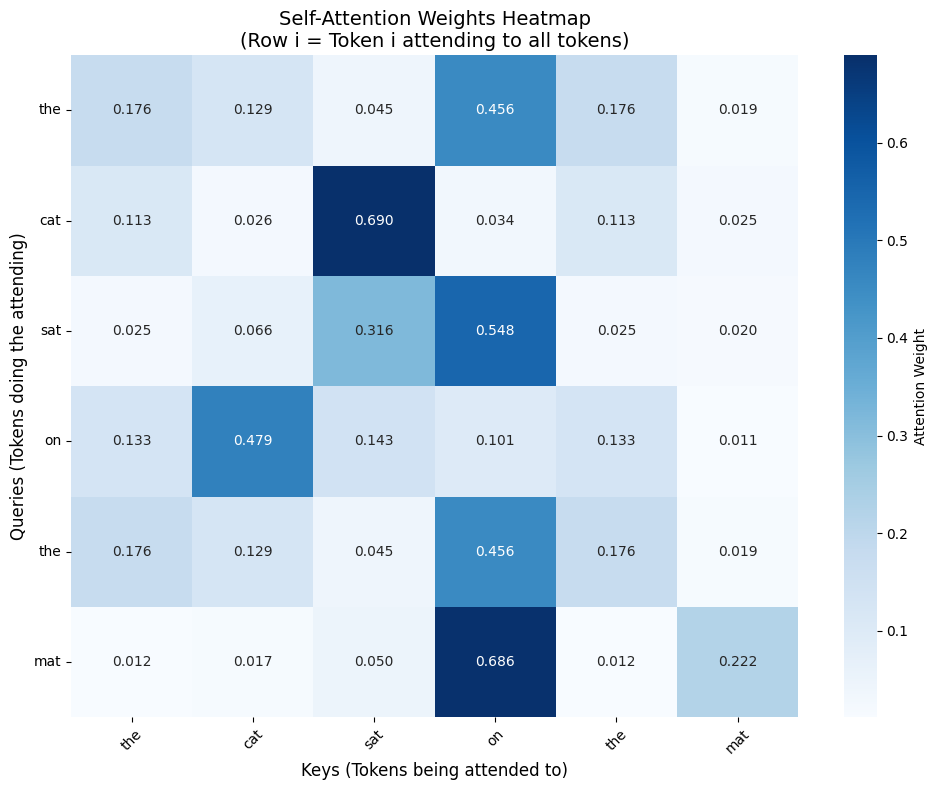

📊 Heatmap explanation:
- Darker blue = higher attention weight
- Each row represents one token's attention distribution
- Each row sums to 1.0 (probability distribution)
- Diagonal often has high values (self-attention)

🔍 Attention Patterns Analysis:
'the' pays most attention to 'on' (weight: 0.456)
'cat' pays most attention to 'sat' (weight: 0.690)
'sat' pays most attention to 'on' (weight: 0.548)
'on' pays most attention to 'cat' (weight: 0.479)
'the' pays most attention to 'on' (weight: 0.456)
'mat' pays most attention to 'on' (weight: 0.686)


In [11]:
#  8: Visualize attention weights as heatmap
print("=" * 60)
print("VISUALIZATION: Attention Weights Heatmap")
print("=" * 60)

# Create heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(attention_weights.detach().numpy(),
           annot=True,
           fmt='.3f',
           xticklabels=tokens,
           yticklabels=tokens,
           cmap='Blues',
           cbar_kws={'label': 'Attention Weight'})

plt.title('Self-Attention Weights Heatmap\n(Row i = Token i attending to all tokens)', fontsize=14)
plt.xlabel('Keys (Tokens being attended to)', fontsize=12)
plt.ylabel('Queries (Tokens doing the attending)', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("📊 Heatmap explanation:")
print("- Darker blue = higher attention weight")
print("- Each row represents one token's attention distribution")
print("- Each row sums to 1.0 (probability distribution)")
print("- Diagonal often has high values (self-attention)")

# Show attention patterns
print(f"\n🔍 Attention Patterns Analysis:")
for i, query_token in enumerate(tokens):
    max_attention_idx = torch.argmax(attention_weights[i]).item()
    max_attention_token = tokens[max_attention_idx]
    max_weight = attention_weights[i, max_attention_idx].item()

    print(f"'{query_token}' pays most attention to '{max_attention_token}' (weight: {max_weight:.3f})")



## 2- Multi-Head Self-Attention: Seeing From Multiple Perspectives



Self-Attention helps model relationships between words across a sentence, regardless of their distance. However, using **just one attention head** limits the types of relationships the model can capture.

---

**Motivation for Multi-Head Attention 🌟**

Multi-Head Attention runs multiple self-attention layers in parallel — each with its own set of learned weights.

📌 Why is this useful?

Each head can focus on **different kinds of patterns** in the sequence:
- One head might learn **grammar**,
- Another might attend to **topic consistency**,
- Another might track **named entities**, and so on.

🧠 How Does It Work?

1. We create multiple sets of Q, K, V:
   - Head₁: (Q₁, K₁, V₁)
   - Head₂: (Q₂, K₂, V₂)
   - ...
   - Headₕ: (Qₕ, Kₕ, Vₕ)

2. Compute attention for each head independently:

$
\text{head}_i = \text{Attention}(Q_i, K_i, V_i)
$

3. Concatenate outputs and project:

$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O
$

🧩 Why It Matters

- Each head learns something unique → richer, more diverse representations.  
- Improves model capacity without requiring huge hidden dimensions.  
- Forms the core of Transformer blocks.


---
## 📊 Dataset: Yahoo Answers Topics

The **Yahoo Answers Topics** dataset is a large-scale, multi-class text classification benchmark derived from the Yahoo! Answers community question-and-answer platform.

### 🔹 Dataset Overview

- **Source:** https://huggingface.co/datasets/yahoo_answers_topics
- **Total Samples:**
  - **Train:** 1,400,000 examples
  - **Test:** 60,000 examples
- **Number of Classes:** 10 (topics/categories)
- **Fields per example:**
  - `question_title`: Short summary of the question
  - `question_content`: Full question body
  - `best_answer`: The best-rated answer from the community
  - `topic`: Integer label (0 to 9) indicating the category

---

## 🧠 Task: Multi-Class Text Classification

The goal is to **predict the topic category** (label `topic` ∈ {0..9}) of a Yahoo! Answers post based on its **question title and content**.

### 🎯 Input:
A combined text string from:
`question_title + " " + question_content`

### 🎯 Output:
A class prediction (integer `0` to `9`) corresponding to one of the following **topics**:

| Label | Topic                         |
|-------|-------------------------------|
| 0     | Society & Culture             |
| 1     | Science & Mathematics         |
| 2     | Health                        |
| 3     | Education & Reference         |
| 4     | Computers & Internet          |
| 5     | Sports                        |
| 6     | Business & Finance            |
| 7     | Entertainment & Music         |
| 8     | Family & Relationships        |
| 9     | Politics & Government         |

---

## 🔧 Task Setup in This Project

- We use a **Multi-Head Attention classifier** built with PyTorch.
- The input texts are **tokenized**, truncated to 100 tokens, and indexed using a custom vocabulary.
- A small subset of the dataset (5,000 train / 1,000 test) is used for fast training. (you can try using all )



In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = load_dataset("yahoo_answers_topics")


train_texts = [
    t + " " + c for t, c in zip(dataset['train']['question_title'], dataset['train']['question_content'])
][:5000]
train_labels = dataset['train']['topic'][:5000]

test_texts = [
    t + " " + c for t, c in zip(dataset['test']['question_title'], dataset['test']['question_content'])
][:1000]
test_labels = dataset['test']['topic'][:1000]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

yahoo_answers_topics/train-00000-of-0000(…):   0%|          | 0.00/241M [00:00<?, ?B/s]

yahoo_answers_topics/train-00001-of-0000(…):   0%|          | 0.00/270M [00:00<?, ?B/s]

yahoo_answers_topics/test-00000-of-00001(…):   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [13]:
# 2. Tokenizer and vocab
def basic_tokenizer(text):
    return re.findall(r"\b\w+\b", text.lower())

def build_vocab(texts, min_freq=5):
    counter = Counter()
    for text in texts:
        tokens = basic_tokenizer(text)
        counter.update(tokens)
    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(train_texts, min_freq=5)

In [14]:
# 3. Dataset
MAX_LEN = 100

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __getitem__(self, idx):
        tokens = basic_tokenizer(self.texts[idx])[:MAX_LEN]
        indices = torch.tensor([self.vocab.get(tok, self.vocab["<unk>"]) for tok in tokens], dtype=torch.long)
        return indices, torch.tensor(self.labels[idx], dtype=torch.long)

    def __len__(self):
        return len(self.texts)

def collate_fn(batch):
    texts, labels = zip(*batch)
    padded = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)
    return padded.to(device), torch.tensor(labels, dtype=torch.long).to(device)

train_ds = TextDataset(train_texts, train_labels, vocab)
test_ds = TextDataset(test_texts, test_labels, vocab)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [15]:
# 4. Model
class MultiHeadAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x_embed = self.embedding(x)
        attn_output, _ = self.attn(x_embed, x_embed, x_embed)
        pooled = self.pool(attn_output.transpose(1, 2)).squeeze(-1)
        return self.fc(pooled)

In [21]:
# 5. Train + Evaluate
model = MultiHeadAttentionClassifier(vocab_size=len(vocab), embed_dim=64, num_heads=4, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from tqdm.auto import tqdm

# Train
epoch_bar = tqdm(range(1, 101), desc="Training", position=0)
for epoch in epoch_bar:
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_bar.set_postfix(epoch=epoch, avg_loss=f"{avg_loss:.4f}")

# Evaluate
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Evaluating", position=1):
        out = model(xb)
        pred = out.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Test Accuracy: 40.60%


## What to Try Next

- **Train on the full dataset:** Use all 1.4 million training examples for better generalization.

- **Deepen the model:**  
  Add multiple transformer encoder layers instead of a single Multi-Head Attention block.

- **Experiment with pretrained embeddings:**  
  Use GloVe, FastText, or fine-tune pretrained transformers like BERT.

- **Improve tokenization:**  
  Switch to subword tokenizers (WordPiece, BPE) for better handling of rare words.



# Contributed by : Lama Ayash